In [1]:
import json
import os.path

import altair as alt
import pandas as pd
import teammachine as tm

alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
# Construct a teammachine Client with credentials downloaded from https://app.teammachine.io/spaces/api-clients
with open('/path/to/credentials.json') as f:
    credentials = json.load(f)
    
client = tm.Client(**credentials)

In [3]:
# At teammachine we use Weave Works (https://www.weave.works/) for releasing our Kubernetes services
# so an indicator of a release is a change to a file in the "releases" folder in our gitops repo

query = client.code_file(path='tm-saas/releases/tm-web.yaml').activity(start_date='2019-06-01')


web_releases = query.request()
web_releases.dataframes.code_file_activity.head()

,code_file_id,tm_id,tm_display_name,node_type,created_at,created_by_tm_id,created_by_tm_display_name,created_by_is_human
0,gip-3MWjEwuKSxdnyY,gic-4IalmhxiMXkPiU,bump versions for tm-svc release\n,CodeCommit,2019-10-23 12:17:41+00:00,iid-6lg5CKjkTiiUr,Uros Rapajic,True
1,gip-3MWjEwuKSxdnyY,gic-2YJoHgXHrYgwkR,Merge branch 'master' of github.com:team-machi...,CodeCommit,2019-10-22 11:05:53+00:00,iid-6lg5CKjkTiiUr,Uros Rapajic,True
2,gip-3MWjEwuKSxdnyY,gic-3ovBWrmc3CKMrG,Prodution release\n\n- Gsuite & calendar integ...,CodeCommit,2019-10-14 10:06:59+00:00,iid-4tnEdSLy5s1lOD,Matti John,True
3,gip-3MWjEwuKSxdnyY,gic-1FVip8vwfdypHf,maintenance release to tm-saas\n,CodeCommit,2019-10-01 08:26:08+00:00,iid-6lg5CKjkTiiUr,Uros Rapajic,True
4,gip-3MWjEwuKSxdnyY,gic-1bop3JS6cT2YYs,Merge branch 'master' of github.com:team-machi...,CodeCommit,2019-09-18 15:34:28+00:00,iid-6lg5CKjkTiiUr,Uros Rapajic,True


In [4]:
# The above query was for a single service, represented by a single file.
# We can get the releases for all services by inspecting all the files in the folder

query = client.code_folder(
    path='tm-saas/releases/'
).fields(
    files=tm.NodeField().activity(start_date='2019-06-01'),
)

In [5]:
releases = query.request()
# the releases result contains three dataframes for folders, files, and files activity
print(releases.dataframes)

<DataFrames: files_activity, code_folder_files, code_folder>


In [6]:
releases.dataframes.files_activity.head()

,files_id,tm_id,tm_display_name,node_type,created_at,created_by_tm_id,created_by_tm_display_name,created_by_is_human
0,gip-3VHoAckqQrqwSL,gic-2VaJUoj0ZZBPl5,add a neo4j\n,CodeCommit,2019-10-11 08:02:22+00:00,iid-6lg5CKjkTiiUr,Uros Rapajic,True
1,gip-62OJS50BzIQQdp,gic-JEzeoekc85mKb,add a neo\n,CodeCommit,2019-09-18 15:48:01+00:00,iid-6lg5CKjkTiiUr,Uros Rapajic,True
2,gip-2Uy0yDoUKOXdp,gic-5TSDYfcRqUKgxD,bump ops reporter to patch db name\n,CodeCommit,2019-08-29 10:55:47+00:00,iid-6lg5CKjkTiiUr,Uros Rapajic,True
3,gip-2Uy0yDoUKOXdp,gic-1a3zzYpE8zYB6x,bump flow and svc for job / task naming change...,CodeCommit,2019-08-29 09:36:47+00:00,iid-6lg5CKjkTiiUr,Uros Rapajic,True
4,gip-2Uy0yDoUKOXdp,gic-3Eo2vW0mJIhIBP,bump versions for next app release\n,CodeCommit,2019-08-23 12:35:14+00:00,iid-6lg5CKjkTiiUr,Uros Rapajic,True


In [7]:
# In GitOps, a commit represents a deployment, however, multiple services could be 
# deployed simultaneously. Because the commits in our DataFrame are grouped by service (i.e. file), 
# we should discard duplicate commit IDs and then group by commit time to calculate deployment frequency

deployments = (releases
               .dataframes
               .files_activity[['tm_id', 'created_at']]
               .drop_duplicates()
               .groupby(pd.Grouper(key='created_at', freq='m'))
               .count())

print(f'Total deployments = {deployments.tm_id.sum()}')

Total deployments = 96


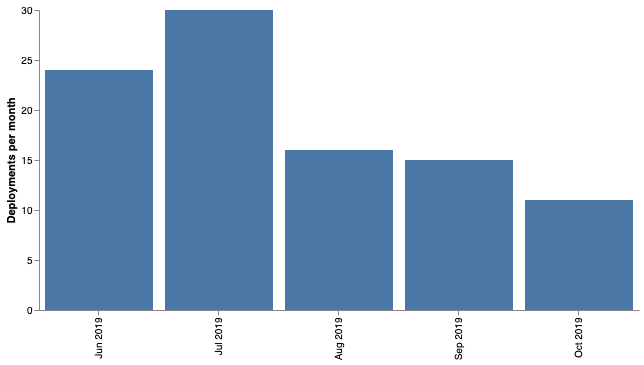

In [8]:
# We can now easily plot the deployment frequency

alt.Chart(
    # altair cannot use the index so reset the dataframe's index
    deployments.reset_index(),
    width=600,
    height=300,
).mark_bar().encode(
    x=alt.X('yearmonth(created_at):O', axis=alt.Axis(title=None)),
    y=alt.Y('sum(tm_id):Q', axis=alt.Axis(title='Deployments per month')),
    tooltip=[alt.Tooltip('sum(tm_id):Q', title='Deployments')],
).configure_axis(grid=False).configure_view(strokeWidth=0)